In [1]:
import sys
import os
import pickle
from collections import Counter
import random
import glob
import scipy.stats as stats

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from gensim.models import Word2Vec
from sklearn import cluster,metrics
from sklearn.preprocessing import StandardScaler, Normalizer


In [2]:
with open("../data/processed/disease_ontograph.pkl", 'rb') as f:
    disease_ontograph = pickle.load(f)
    #Remove unconnected components
components = [i for i in nx.connected_components(disease_ontograph)]
disease_ontograph = disease_ontograph.subgraph(components[0]).copy()

diseases = [n for n in disease_ontograph.nodes if disease_ontograph.nodes[n].get('label') ==  'disease']

In [3]:
disease_cluster_data = pd.read_csv("../data/processed/disease_cluster_information.csv")

In [4]:
N = 80
L = 25
D = 512 
K_dim = 10
embedding_file = "../data/embeddings/ontograph_embed_N{0}_L{1}_D{2}_K{3}.model".format(N,L,D,K_dim)
model = Word2Vec.load(embedding_file)
disease_vectors = model.wv[diseases]
standard_vectors = StandardScaler().fit_transform(disease_vectors)
normalized_vectors = Normalizer().fit_transform(standard_vectors)

In [6]:
m_file = "../data/clusters/kmeans/ontograph_embed_N{0}_L{1}_D{2}_K{3}_KMEANS_KOPT37.pkl".format(N,L,D,K_dim)
with open(m_file, 'rb') as f:
    cluster_model = pickle.load(f)

In [7]:
cluster_model.labels_

array([13,  2, 27, ..., 13,  8, 17], dtype=int32)

In [8]:
cluster_map = {dis:cluster_model.labels_[i] for i,dis in enumerate(diseases)}
disease_cluster_data.Cluster = pd.Series([cluster_map.get(i) for i in disease_cluster_data.GARD_ID])

In [9]:
diseases_in_graph = [n for n in disease_ontograph.nodes if disease_ontograph.nodes[n].get('label') ==  'disease']

with open("../data/walks/walks_N80_L25.txt",'r') as wfile:
    walks = wfile.readlines()    

cluster_map = {d:cluster_model.labels_[i] for i,d in enumerate(diseases_in_graph)}

diseases_in_walks = list(set([w.split()[0] for w in walks]))

In [10]:
gard_gene_data = pd.read_csv("../data/raw/gard2gene.csv")
gard_gene_data = gard_gene_data[gard_gene_data.Gene_ID.isnull()==False]
gard_gene_data.Gene_ID = gard_gene_data.Gene_ID.astype('int')
gard_gene_data.head()

,GARD_ID,GARD_Disease,Disease_Gene_Association,Gene_Symbol,Gene_Name,Gene_Refs,OMIM,Ensembl,Genatlas,SwissProt,HGNC,Reactome,IUPHAR,Gene_ID
0,GARD:0000001,GRACILE syndrome,Disease-causing germline mutation(s) in,BCS1L,"BCS1 homolog, ubiquinol-cytochrome c reductase...","['OMIM:603647', 'Ensembl:ENSG00000074582', 'Ge...",603647.0,ENSG00000074582,BCS1L,Q9Y276,1020.0,Q9Y276,NaN,617
1,GARD:0000003,Ablepharon macrostomia syndrome,Disease-causing germline mutation(s) in,TWIST2,twist family bHLH transcription factor 2,"['Ensembl:ENSG00000233608', 'OMIM:607556', 'Re...",607556.0,ENSG00000233608,TWIST2,Q8WVJ9,20670.0,Q8WVJ9,NaN,117581
3,GARD:0000005,Abetalipoproteinemia,Disease-causing germline mutation(s) in,MTTP,microsomal triglyceride transfer protein,"['Ensembl:ENSG00000138823', 'Genatlas:MTTP', '...",157147.0,ENSG00000138823,MTTP,P55157,7467.0,P55157,NaN,4547
5,GARD:0000007,Acromicric dysplasia,Disease-causing germline mutation(s) in,FBN1,fibrillin 1,"['Reactome:P35555', 'Genatlas:FBN1', 'OMIM:134...",134797.0,ENSG00000166147,FBN1,P35555,3603.0,P35555,NaN,2200
6,GARD:0000007,Acromicric dysplasia,Disease-causing germline mutation(s) in,LTBP3,latent transforming growth factor beta binding...,"['Reactome:Q9NS15', 'Genatlas:LTBP3', 'Ensembl...",602090.0,ENSG00000168056,LTBP3,Q9NS15,6716.0,Q9NS15,NaN,4054


In [11]:
gard_gene_data['Cluster'] = [cluster_map.get(i) for i in gard_gene_data.GARD_ID]

In [12]:
[i for i in gard_gene_data.GARD_ID if i not in cluster_map]

['GARD:0004950']

In [13]:
pd.Series([cluster_map.get(i) for i in gard_gene_data.GARD_ID])

0       17.0
1       12.0
2        2.0
3       16.0
4       16.0
        ... 
4278    13.0
4279    36.0
4280     8.0
4281    13.0
4282    13.0
Length: 4283, dtype: float64

In [14]:
#gard_gene_data.dropna(subset=['Cluster']).shape
gard_gene_data.shape

(4283, 15)

In [15]:
cluster_disease_genes = gard_gene_data[['GARD_ID','GARD_Disease','Gene_Symbol','Gene_ID']].merge(disease_cluster_data)

In [16]:
cluster_disease_genes.to_csv("../data/processed/cluster_all_targets.csv",index=False)

In [ ]:
p_dis = []
p_dis_target = []

for i,row in cluster_disease_genes.iterrows():

    focal_gene = row['Gene_ID']
    focal_cluster = row['Cluster']
    N_dis = len(diseases)
    N_dis_target = cluster_disease_genes.shape[0]

    n_dis = sum(disease_cluster_data['Cluster'] == focal_cluster)
    n_dis_target = sum(cluster_disease_genes['Cluster'] == focal_cluster)

    K = sum(cluster_disease_genes['Gene_ID'] == focal_gene)
    k = sum((cluster_disease_genes['Gene_ID'] == focal_gene) & (cluster_disease_genes['Cluster'] == focal_cluster))
    
    p_dis.append((1 - stats.hypergeom.cdf(k-1, N_dis,K, n_dis)))
    #p_dis_target.append((1 - stats.hypergeom.cdf(k-1, N_dis_target, K, n_dis_target)))

In [ ]:
cluster_disease_genes['p_dis'] = p_dis
#cluster_disease_genes['p_dis_target'] = p_dis_target

In [ ]:
enriched_genes = cluster_disease_genes[(cluster_disease_genes['p_dis'] < 1/len(p_dis)) & 
                      (cluster_disease_genes['Cluster'] == 12)]

In [ ]:
enriched_genes

# Overlap with Tox21 compound cluster

In [90]:
tox21_clusters = pd.read_csv("../data/processed/pharos_and_drughub.csv")
combined_annotations = cluster_disease_genes.merge(tox21_clusters,left_on='Gene_Symbol', right_on='target_gene',how='inner')

In [18]:
tox21_cluster_targets = tox21_clusters[['cluster','target_gene']]
tox21_cluster_targets.columns = ['cluster_tox21','gene']

In [19]:
gard_cluster_targets = cluster_disease_genes[['Cluster','Gene_Symbol']]
gard_cluster_targets.columns = ['cluster_gard','gene']

In [20]:
combined_cluster_targets = gard_cluster_targets.merge(tox21_cluster_targets, left_on='gene', right_on='gene',how='inner')

In [21]:
combined_cluster_targets

,cluster_gard,gene,cluster_tox21
0,26.0,CACNA1A,1
1,26.0,CACNA1A,31
2,26.0,CACNA1A,48
3,26.0,CACNA1A,100
4,8.0,CACNA1A,1
...,...,...,...
2824,17.0,CA5A,113
2825,17.0,CA5A,114
2826,17.0,CA5A,138
2827,17.0,CA5A,140


In [22]:
combined_annotations

,GARD_ID,GARD_Disease,Gene_Symbol,Gene_ID,GARD_Categories,Cluster,Unnamed: 0,cas,cluster,inchikey,target_gene
0,GARD:0000011,Alternating hemiplegia of childhood,CACNA1A,773,"['Nervous System Diseases', 'Congenital and Ge...",26.0,16,53179-11-6,1,RDOIQAHITMMDAJ-UHFFFAOYSA-N,CACNA1A
1,GARD:0000011,Alternating hemiplegia of childhood,CACNA1A,773,"['Nervous System Diseases', 'Congenital and Ge...",26.0,752,52-53-9,31,SGTNSNPWRIOYBX-UHFFFAOYSA-N,CACNA1A
2,GARD:0000011,Alternating hemiplegia of childhood,CACNA1A,773,"['Nervous System Diseases', 'Congenital and Ge...",26.0,970,52-01-7,48,LXMSZDCAJNLERA-ZHYRCANASA-N,CACNA1A
3,GARD:0000011,Alternating hemiplegia of childhood,CACNA1A,773,"['Nervous System Diseases', 'Congenital and Ge...",26.0,1808,60142-96-3,100,UGJMXCAKCUNAIE-UHFFFAOYSA-N,CACNA1A
4,GARD:0009602,Episodic ataxia with nystagmus,CACNA1A,773,"['Nervous System Diseases', 'Congenital and Ge...",8.0,16,53179-11-6,1,RDOIQAHITMMDAJ-UHFFFAOYSA-N,CACNA1A
...,...,...,...,...,...,...,...,...,...,...,...
2824,GARD:0013201,Carbonic anhydrase VA deficiency,CA5A,763,Congenital and Genetic Diseases,17.0,5788,59-66-5,113,BZKPWHYZMXOIDC-UHFFFAOYSA-N,CA5A
2825,GARD:0013201,Carbonic anhydrase VA deficiency,CA5A,763,Congenital and Genetic Diseases,17.0,5902,97240-79-4,114,KJADKKWYZYXHBB-XBWDGYHZSA-N,CA5A
2826,GARD:0013201,Carbonic anhydrase VA deficiency,CA5A,763,Congenital and Genetic Diseases,17.0,6552,124-09-4,138,NAQMVNRVTILPCV-UHFFFAOYSA-N,CA5A
2827,GARD:0013201,Carbonic anhydrase VA deficiency,CA5A,763,Congenital and Genetic Diseases,17.0,6635,77-36-1,140,JIVPVXMEBJLZRO-UHFFFAOYSA-N,CA5A


In [40]:
tox_clust = 78
gard_clust = 23
tox_targ = tox21_cluster_targets[tox21_cluster_targets['cluster_tox21'] == tox_clust]
gard_targ = gard_cluster_targets[gard_cluster_targets['cluster_gard'] == gard_clust]

(array([35.,  0.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  2.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

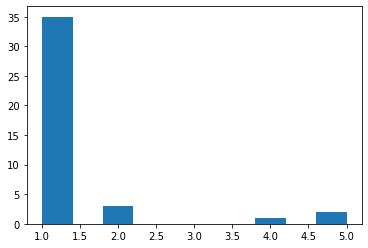

In [41]:
plt.hist(tox_targ.groupby('gene').size())

In [42]:
all_genes = pd.concat([tox_targ['gene'], gard_targ['gene']], axis=0).unique()

In [45]:
gard_targ

,cluster_gard,gene
146,23.0,GATA6
154,23.0,CYP19A1
682,23.0,ABCC8
683,23.0,KCNJ11
684,23.0,HYMAI
685,23.0,PLAGL1
686,23.0,ZFP57
925,23.0,GCK
1012,23.0,LMNA
1070,23.0,LMNA


In [50]:
target_cocount = []
for tox_clust in tox21_cluster_targets['cluster_tox21'].unique():
    
    tox_targ = tox21_cluster_targets[tox21_cluster_targets['cluster_tox21'] == tox_clust]
    
    for gard_clust in gard_cluster_targets['cluster_gard'].unique():
        
        gard_targ = gard_cluster_targets[gard_cluster_targets['cluster_gard'] == gard_clust]
        
        all_genes = pd.concat([tox_targ['gene'], gard_targ['gene']], axis=0).unique()
        
        for gene in all_genes:
            tox_count  = sum(tox_targ['gene'] == gene)
            gard_count  = sum(gard_targ['gene'] == gene)
        
            target_cocount.append({'Gene_Symbol':gene,'cluster_tox21':tox_clust,'cluster_gard':gard_clust,
                                   'tox_count':tox_count,'gard_count':gard_count})

In [61]:
[i for i in target_cocount if (i['gard_count']>2)&(i['tox_count']>2)]

[{'Gene_Symbol': 'ABCC8',
  'cluster_tox21': 78,
  'cluster_gard': 23.0,
  'tox_count': 5,
  'gard_count': 3},
 {'Gene_Symbol': 'KCNJ11',
  'cluster_tox21': 78,
  'cluster_gard': 23.0,
  'tox_count': 5,
  'gard_count': 3},
 {'Gene_Symbol': 'SCN5A',
  'cluster_tox21': 101,
  'cluster_gard': 24.0,
  'tox_count': 3,
  'gard_count': 4}]

In [64]:
target_coc_df = pd.DataFrame(target_cocount)


In [ ]:
target_coc_df.to_csv("../data/processed/tox_gard_target_cooc.csv",index=False)

In [78]:
target_coc_df[(target_coc_df['tox_count']>1) & (target_coc_df['gard_count']>1)]

,Gene_Symbol,cluster_tox21,cluster_gard,tox_count,gard_count
5577,CALM1,1,24.0,4,2
65047,SCN5A,14,24.0,2,4
65048,CACNA1C,14,24.0,2,2
69026,AR,16,21.0,3,2
73129,AR,17,21.0,4,2
77070,SCN4A,18,5.0,2,3
77925,SCN5A,18,24.0,2,4
102507,ABCC8,24,23.0,2,3
102509,KCNJ11,24,23.0,2,3
114253,ATP1A3,27,8.0,3,2


In [74]:
key_examples=[]
for i in target_cocount:
    if (i['gard_count']>1) & (i['tox_count']>1):
        key_examples.append(combined_annotations[
            (combined_annotations['Cluster']==i['cluster_gard']) &
            (combined_annotations['cluster']==i['cluster_tox21']) &
            (combined_annotations['Gene_Symbol']==i['Gene_Symbol'])
        ])


In [93]:
tox21_cooc_example = pd.concat(key_examples)[['Cluster','GARD_ID','GARD_Disease','GARD_Categories','cluster','cas','inchikey','Gene_Symbol','Gene_ID']]
tox21_cooc_example.columns=['GARD_Cluster','GARD_ID','GARD_Disease','GARD_Categories','Tox21_Cluster','cas','inchikey','Gene_Symbol','Gene_ID']

with pd.ExcelWriter("../data/processed/gard-tox21-cluster-overlap-example.xlsx") as writer:  
    tox21_cooc_example.to_excel(writer, sheet_name='Overlapping_Targets',index=False)
    target_coc_df[(target_coc_df['tox_count']>1) & (target_coc_df['gard_count']>1)].to_excel(writer, sheet_name='Overlap_Summary',index=False)
    cluster_disease_genes[cluster_disease_genes['Cluster'].isin(tox21_cooc_example['GARD_Cluster'].unique())].to_excel(writer, sheet_name='GARD_Clusters',index=False)
    tox21_clusters[tox21_clusters['cluster'].isin(tox21_cooc_example['Tox21_Cluster'].unique())].to_excel(writer, sheet_name='Tox21_Clusters',index=False)

In [92]:
tox21_clusters[tox21_clusters['cluster'].isin(tox21_cooc_example['Tox21_Cluster'].unique())]

,Unnamed: 0,cas,cluster,inchikey,target_gene
0,1,303-49-1,1,GDLIGKIOYRNHDA-UHFFFAOYSA-N,GSTP1
1,2,303-49-1,1,GDLIGKIOYRNHDA-UHFFFAOYSA-N,HTR2A
2,3,303-49-1,1,GDLIGKIOYRNHDA-UHFFFAOYSA-N,HTR2B
3,4,303-49-1,1,GDLIGKIOYRNHDA-UHFFFAOYSA-N,HTR2C
4,5,303-49-1,1,GDLIGKIOYRNHDA-UHFFFAOYSA-N,SLC6A2
...,...,...,...,...,...
5301,6682,179324-69-7,142,GXJABQQUPOEUTA-RDJZCZTQSA-N,NFKB2
5302,6683,94-37-1,142,KNBRWWCHBRQLNY-UHFFFAOYSA-N,MGLL
5303,6684,128-04-1,142,VMSRVIHUFHQIAL-UHFFFAOYSA-M,CA1
5304,6685,128-04-1,142,VMSRVIHUFHQIAL-UHFFFAOYSA-M,CA12


In [89]:
cluster_disease_genes[cluster_disease_genes['Cluster'].isin(tox21_cooc_example['GARD_Cluster'].unique())]

,GARD_ID,GARD_Disease,Gene_Symbol,Gene_ID,GARD_Categories,Cluster
5,GARD:0000011,Alternating hemiplegia of childhood,CACNA1A,773,"['Nervous System Diseases', 'Congenital and Ge...",26.0
6,GARD:0000011,Alternating hemiplegia of childhood,ATP1A2,477,"['Nervous System Diseases', 'Congenital and Ge...",26.0
7,GARD:0000011,Alternating hemiplegia of childhood,ATP1A3,478,"['Nervous System Diseases', 'Congenital and Ge...",26.0
8,GARD:0000011,Alternating hemiplegia of childhood,SLC1A3,6507,"['Nervous System Diseases', 'Congenital and Ge...",26.0
9,GARD:0000013,Gillespie syndrome,ITPR1,3708,"['Congenital and Genetic Diseases', 'Nervous S...",8.0
...,...,...,...,...,...,...
4276,GARD:0013339,BENTA disease,CARD11,84433,NaN,13.0
4277,GARD:0013354,Morning glory syndrome,PAX6,5080,"['Eye diseases', 'Congenital and Genetic Disea...",36.0
4278,GARD:0013381,Leukoencephalopathy with thalamus and brainste...,EARS2,124454,"['Nervous System Diseases', 'Congenital and Ge...",8.0
4279,GARD:0013390,12q14 microdeletion syndrome,LEMD3,23592,"['Nervous System Diseases', 'Musculoskeletal D...",13.0


In [ ]:
import seaborn as sns

In [ ]:
histplot = sns.jointplot(x="tox_count", 
              y="gard_count",
             edgecolor="white",
              kind="hist",
             data=target_coc_df[(target_coc_df['tox_count']>0) & (target_coc_df['gard_count']>0) ]);

#plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
#cbar_ax = histplot.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
#plt.colorbar(cax=cbar_ax)
#plt.show()
#plt.title("Scatter Plot with Marginal Histograms: Seaborn", size=18, pad=80)
plt.savefig("../fig/marginal_plot.png",figsize=(6,6), dpi=150)

## Permutation based test with random walk enrichment

In [14]:
walk_annotations = pd.read_table("../data/processed/cluster_walk_annotations.txt",index_col=None)

In [15]:
walk_annotations

,Cluster,Disease,Annotation_Type,Annotation,Count
0,27,GARD:0010397,HPO,HP:0007688,80
1,27,GARD:0010397,HPO,HP:0001133,106
2,27,GARD:0010397,HPO,HP:0007843,81
3,27,GARD:0010397,HPO,HP:0000639,5
4,27,GARD:0010397,HPO,HP:0002705,1
...,...,...,...,...,...
1594374,13,GARD:0003845,GO,GO:0045893,1
1594375,13,GARD:0003845,GO,GO:0065003,1
1594376,13,GARD:0003845,SmallMolecule,CHEBI:22586,1
1594377,13,GARD:0003845,SmallMolecule,PUBCHEM:139036609,1


In [28]:
walk_annotation_counts = walk_annotations[['Cluster','Disease','Annotation','Count']]
walk_annotation_counts

,Cluster,Disease,Annotation,Count
0,27,GARD:0010397,HP:0007688,80
1,27,GARD:0010397,HP:0001133,106
2,27,GARD:0010397,HP:0007843,81
3,27,GARD:0010397,HP:0000639,5
4,27,GARD:0010397,HP:0002705,1
...,...,...,...,...
1594374,13,GARD:0003845,GO:0045893,1
1594375,13,GARD:0003845,GO:0065003,1
1594376,13,GARD:0003845,CHEBI:22586,1
1594377,13,GARD:0003845,PUBCHEM:139036609,1


In [34]:
gene_annotation_counts = disease_cluster_data[['Cluster','GARD_ID']].merge(
    gard_gene_data[['GARD_ID','Gene_Symbol']]
)

gene_annotation_counts['Count'] = 1

gene_annotation_counts.columns = ['Cluster','Disease','Annotation','Count']

In [35]:
gene_annotation_counts

,Cluster,Disease,Annotation,Count
0,8.0,GARD:0000334,ADAR,1
1,34.0,GARD:0000448,EPG5,1
2,36.0,GARD:0000594,TYR,1
3,22.0,GARD:0001996,ABCB6,1
4,15.0,GARD:0002566,MYO5A,1
...,...,...,...,...
4277,14.0,GARD:0010147,SIX1,1
4278,14.0,GARD:0010147,EYA1,1
4279,14.0,GARD:0010147,SIX5,1
4280,14.0,GARD:0010148,EYA1,1


In [88]:
walk_annotation_counts.groupby(['Cluster','Annotation']).agg({'Count':'sum'})

Count
Cluster Annotation           
0       CHEBI:10036         2
        CHEBI:12427         1
        CHEBI:13193         1
        CHEBI:134094        1
        CHEBI:134438        2
...                       ...
36      UBERON:0035074      1
        UBERON:0036293      3
        UBERON:0037191      1
        UBERON:1000023      1
        UBERON:1000024      1

[395943 rows x 1 columns]

In [37]:
walk_annotation_counts.pivot_table('Count', 'Cluster', 'Annotation',aggfunc='sum').fillna(0)

Annotation,BFO:0000002,BFO:0000004,BFO:0000006,BFO:0000020,BFO:0000040,BFO:0000141,CARO:0000000,CARO:0000003,CARO:0030000,CHEBI:10033,...,UBERON:1000024,UBERON:2001457,UBERON:4100000,UBERON:5002544,UBERON:7500037,UBERON:7500050,UBERON:8410001,UBERON:8410004,https://github.com/cmungall,https://github.com/dosumis
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,6.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,11.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,3.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
walk_count_matrix_obs = walk_annotations.pivot_table('Count', 'Cluster', 'Annotation',aggfunc='sum').fillna(0)

In [ ]:
cluster_gene_counts = cluster_disease_genes.groupby(['Cluster','Gene_ID']).agg({'GARD_ID':'count'}).reset_index()

In [ ]:
cluster_gene_counts['GARD_ID'].describe()

In [ ]:
cluster_gene_counts.groupby('Gene_ID').agg({'GARD_ID':'sum'}).reset_index()

In [ ]:
count_matrix_obs = cluster_gene_counts.pivot_table('GARD_ID', 'Cluster', 'Gene_ID')
count_matrix_obs.head()

In [ ]:
count_matrix_obs.reset_index().melt(id_vars='Cluster').dropna().sort_values(['Cluster','Gene_ID'])

In [ ]:
len(cluster_disease_genes['GARD_ID'].unique())

In [ ]:
sum((cluster_disease_genes['Cluster'] == 0))

In [ ]:
cluster_disease_genes[(cluster_disease_genes['Cluster'] == 0) & (cluster_disease_genes['Gene_ID'] == 18)]

In [11]:
disease_cluster_data

,GARD_ID,GARD_Disease,GARD_Categories,Cluster
0,GARD:0000105,Oculocerebral syndrome with hypopigmentation,"['Congenital and Genetic Diseases', 'Skin Dise...",4.0
1,GARD:0000334,Oculocerebral syndrome with hypopigmentation,"['Skin Diseases', 'Congenital and Genetic Dise...",8.0
2,GARD:0000404,Osteoporosis oculocutaneous hypopigmentation s...,"['Congenital and Genetic Diseases', 'Musculosk...",36.0
3,GARD:0000407,Ermine phenotype,"['Congenital and Genetic Diseases', 'Ear, Nose...",15.0
4,GARD:0000448,Vici syndrome,"['Congenital and Genetic Diseases', 'Nervous S...",34.0
...,...,...,...,...
3707,GARD:0010147,Branchiootorenal syndrome,"['Congenital and Genetic Diseases', 'Kidney an...",14.0
3708,GARD:0010148,Branchiootic syndrome,"['Congenital and Genetic Diseases', 'Ear, Nose...",14.0
3709,GARD:0010280,Klippel Feil syndrome,"['Congenital and Genetic Diseases', 'Musculosk...",14.0
3710,GARD:0010300,Microtia eye coloboma and imperforation of the...,"['Congenital and Genetic Diseases', 'Eye disea...",36.0


In [12]:
gard_gene_data

,GARD_ID,GARD_Disease,Disease_Gene_Association,Gene_Symbol,Gene_Name,Gene_Refs,OMIM,Ensembl,Genatlas,SwissProt,HGNC,Reactome,IUPHAR,Gene_ID
0,GARD:0000001,GRACILE syndrome,Disease-causing germline mutation(s) in,BCS1L,"BCS1 homolog, ubiquinol-cytochrome c reductase...","['OMIM:603647', 'Ensembl:ENSG00000074582', 'Ge...",603647.0,ENSG00000074582,BCS1L,Q9Y276,1020.0,Q9Y276,NaN,617
1,GARD:0000003,Ablepharon macrostomia syndrome,Disease-causing germline mutation(s) in,TWIST2,twist family bHLH transcription factor 2,"['Ensembl:ENSG00000233608', 'OMIM:607556', 'Re...",607556.0,ENSG00000233608,TWIST2,Q8WVJ9,20670.0,Q8WVJ9,NaN,117581
3,GARD:0000005,Abetalipoproteinemia,Disease-causing germline mutation(s) in,MTTP,microsomal triglyceride transfer protein,"['Ensembl:ENSG00000138823', 'Genatlas:MTTP', '...",157147.0,ENSG00000138823,MTTP,P55157,7467.0,P55157,NaN,4547
5,GARD:0000007,Acromicric dysplasia,Disease-causing germline mutation(s) in,FBN1,fibrillin 1,"['Reactome:P35555', 'Genatlas:FBN1', 'OMIM:134...",134797.0,ENSG00000166147,FBN1,P35555,3603.0,P35555,NaN,2200
6,GARD:0000007,Acromicric dysplasia,Disease-causing germline mutation(s) in,LTBP3,latent transforming growth factor beta binding...,"['Reactome:Q9NS15', 'Genatlas:LTBP3', 'Ensembl...",602090.0,ENSG00000168056,LTBP3,Q9NS15,6716.0,Q9NS15,NaN,4054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7779,GARD:0013339,BENTA disease,Disease-causing germline mutation(s) (gain of ...,CARD11,caspase recruitment domain family member 11,"['HGNC:16393', 'Ensembl:ENSG00000198286', 'OMI...",607210.0,ENSG00000198286,CARD11,Q9BXL7,16393.0,Q9BXL7,NaN,84433
7780,GARD:0013354,Morning glory syndrome,Candidate gene tested in,PAX6,paired box 6,"['Reactome:P26367', 'Genatlas:PAX6', 'OMIM:607...",607108.0,ENSG00000007372,PAX6,P26367,8620.0,P26367,NaN,5080
7787,GARD:0013381,Leukoencephalopathy with thalamus and brainste...,Disease-causing germline mutation(s) in,EARS2,"glutamyl-tRNA synthetase 2, mitochondrial","['OMIM:612799', 'Reactome:Q5JPH6', 'Ensembl:EN...",612799.0,ENSG00000103356,EARS2,Q5JPH6,29419.0,Q5JPH6,NaN,124454
7790,GARD:0013390,12q14 microdeletion syndrome,Role in the phenotype of,LEMD3,LEM domain containing 3,"['Reactome:Q9Y2U8', 'SwissProt:Q9Y2U8', 'OMIM:...",607844.0,ENSG00000174106,LEMD3,Q9Y2U8,28887.0,Q9Y2U8,NaN,23592


In [43]:
def permute_annotation_counts(diseases,annotation_counts,cluster_model,P):
    
    count_matrix = annotation_counts.pivot_table('Count', 'Cluster', 'Annotation',aggfunc='sum').fillna(0)
    perm_results = np.zeros(count_matrix.shape)
    
    annotation_counts_perm = annotation_counts.copy()
    cluster_labels_perm = cluster_model.labels_
    
    for i in range(P):
        np.random.shuffle(cluster_labels_perm)
        cluster_map_perm = {dis:cluster_labels_perm[i] for i,dis in enumerate(diseases)}
    
        annotation_counts_perm.Cluster = pd.Series([cluster_map_perm.get(i) for i in annotation_counts_perm.Disease])
        
        count_matrix_perm = annotation_counts_perm.pivot_table('Count', 'Cluster', 'Annotation',aggfunc='sum').fillna(0)
        
        perm_results += np.greater_equal(count_matrix_perm.loc[count_matrix.index],count_matrix)*1
    
    return perm_results

permute_annotation_counts(diseases,gene_annotation_counts,cluster_model,10)

Annotation,A2ML1,AAAS,AAGAB,AARS,AARS2,AASS,ABAT,ABCA1,ABCA12,ABCA3,...,ZNF408,ZNF41,ZNF423,ZNF469,ZNF513,ZNF592,ZNF711,ZNF81,ZNHIT3,ZSWIM6
Cluster,,,,,,,,,,,,,,,,,,,,,
0.0,10.0,10.0,10.0,10.0,1.0,10.0,0.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,0.0,0.0,10.0,10.0,10.0,0.0,0.0,0.0,10.0
2.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,0.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
4.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
5.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
6.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
7.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
8.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


In [ ]:
perm_results = np.zeros(count_matrix_obs.shape)
walk_perm_results = np.zeros(walk_count_matrix_obs.shape)
disease_cluster_data_perm = disease_cluster_data.copy()
walk_annotations_perm = walk_annotations.copy()
cluster_labels_perm = cluster_model.labels_

P = 100000
for i in range(P):
    np.random.shuffle(cluster_labels_perm)
    cluster_map_perm = {dis:cluster_labels_perm[i] for i,dis in enumerate(diseases)}
    disease_cluster_data_perm.Cluster = pd.Series([cluster_map_perm.get(i) for i in disease_cluster_data_perm.GARD_ID])
    walk_annotations_perm.Cluster = pd.Series([cluster_map_perm.get(i) for i in walk_annotations_perm.Disease])
    
    cluster_disease_genes_perm = gard_gene_data[['GARD_ID','GARD_Disease','Gene_Symbol','Gene_ID']].merge(disease_cluster_data_perm)
    cluster_gene_counts_perm = cluster_disease_genes_perm.groupby(['Cluster','Gene_ID']).agg({'GARD_ID':'count'}).reset_index()
    count_matrix_perm = cluster_gene_counts_perm.pivot_table('GARD_ID', 'Cluster', 'Gene_ID').fillna(0)
    
    walk_count_matrix_perm =  walk_annotations_perm.pivot_table('Count', 'Cluster', 'Annotation',aggfunc='sum').fillna(0)
    
    perm_results += np.greater_equal(count_matrix_perm.loc[count_matrix_obs.index],count_matrix_obs)*1
    walk_perm_results += np.greater_equal(walk_count_matrix_perm,walk_count_matrix_obs)*1

In [85]:
0.05/100000

5e-07

In [ ]:
perm_results_condensed = cluster_gene_counts.merge(perm_results.reset_index().melt(id_vars='Cluster').sort_values(['Cluster','Gene_ID']))

In [ ]:
perm_results_condensed['perm_p'] = np.fmax(np.ones(perm_results_condensed.shape[0]),perm_results_condensed['value'].values)/P

In [ ]:
significant_results = perm_results_condensed[perm_results_condensed['perm_p'] < 0.05/perm_results_condensed.shape[0]].drop('GARD_ID',axis=1).merge(cluster_disease_genes)

In [ ]:
significant_results[significant_results['GARD_Disease']=='Brugada syndrome']

In [ ]:
significant_results[significant_results['Cluster']==24]

In [ ]:
disease_cluster_data[disease_cluster_data['GARD_Disease']=="Dravet syndrome"]

In [ ]:
disease_cluster_data[disease_cluster_data['Cluster']==23]

In [ ]:
plt.hist(perm_results_condensed['perm_p'])
plt.show()

In [ ]:
sorted_p = perm_results_condensed['perm_p'].sort_values(ascending=False)
expected = np.arange(1+perm_results_condensed.shape[0],1,-1)/perm_results_condensed.shape[0]

In [ ]:
significant_results.to_csv("../data/processed/cluster_enrichment_results.csv")

# Clustered embeddings visual

In [ ]:
cluster_labels = cluster_model.predict(normalized_vectors)

In [ ]:
cluster_count = Counter(cluster_labels)
cluster_dist = Counter(sorted(cluster_count.values(),reverse=True))
clust, cnt = zip(*cluster_dist.items())

In [ ]:
sorted_labels = cluster_labels[np.argsort(cluster_labels)]
hlines=[]
for i in set(sorted_labels):
    if i > 0:
        hlines.append(list(sorted_labels).index(i))

In [ ]:
random_order = [i for i in range(len(disease_vectors))]
random.shuffle(random_order)

fig = plt.figure(figsize=(10,8), facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.imshow(normalized_vectors[random_order],aspect='auto',cmap='bwr')
plt.grid(b=None)
plt.title("Randomized embeddings",size=20)
plt.ylabel('Disease',size=14)
plt.xlabel('Embedding dimension',size=14)

plt.subplot(1,2,2)
plt.imshow(normalized_vectors[np.argsort(cluster_labels)],aspect='auto',cmap='bwr',label="Normalized embedding value")
for i in hlines:
    plt.axhline(y=i, color='black', linestyle='-',lw=.5)
plt.grid(b=None)
plt.title("Cluster sorted diseases",size=20)
plt.ylabel('Diseases (sorted by cluster)',size=20)
plt.xlabel('Disease network derived feature',size=20)

# setup the colorbar
normalize = mcolors.Normalize(vmin=normalized_vectors.min(), vmax=normalized_vectors.max())
colormap = cm.bwr

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(normalized_vectors)
plt.colorbar(scalarmappaple)

plt.show()